# Investigating the non-linear phase readout


In [2]:
import scipy.constants as cont
import numpy as np
from scipy.fft import fft, fftfreq

import copy
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from fticr_toolkit import ame
from fticr_toolkit import ideal_trap_physics as ideal
from fticr_toolkit import systematics as sys_fun

### Non linear phase readout

This is something we observe when scanning the Phase accumulation time (PAT) with the idea that the resulting reduced cyclotron phases are spanned over 2pi. PAT steps below 1 ms are not possible due to mixing with the local oscillator on a full kHz frequency (ok sure, you can do it, but than you have to adjust the measured phase), but steps at ms precision can be found to get the right phases as N%2pi.

In the next cell we will "simulate" the non-linear effect (only the shift in phase) and especially calculate the effect of these phase effects on the difference of the long and short (reference) phase.

0.0


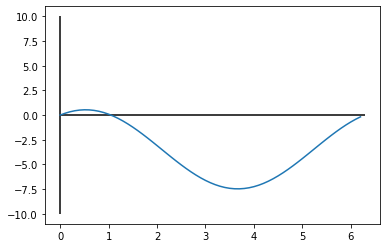

2.0


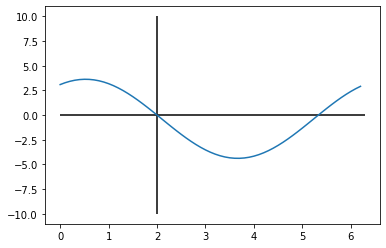

4.0


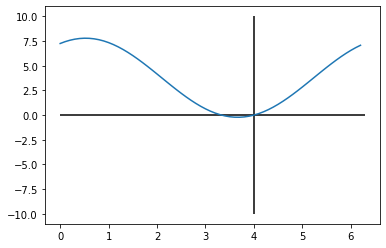

6.0


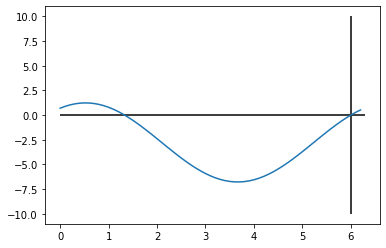

7.77677916064356 -7.461678586601147


In [2]:
x = np.arange(0, 2*np.pi, 1e-1) # these represent the values the actual phase the ion could have
y = np.arange(0, 2*np.pi, 2) # for the long(x) and for the reference(y) phase
matrix = []
for ly in y:
    # 4* sin (...) estimating a non-linear, sinusoidial, phase conversion effect with amplitude 4°
    ypart = 4*np.sin(ly+np.pi/3) # 0.1 seconds baseline reference PAT, phase offset due to 
    print(ly)
    #ypart = 4*np.sin(0.1+np.pi/32+ly) # 0.1 seconds baseline reference PAT, phase offset due to 
    # excitation (pi/something), actuall phase of the ion for a slightly different PAT
    lx = 4*np.sin(x+np.pi/3) - ypart # 40.1 long measurement phase
    #lx = 4*np.sin(40.1+np.pi/32+x) - ypart # 40.1 long measurement phase
    plt.plot(x, lx)
    plt.vlines([ly], -10, 10)
    matrix.append(lx)
    plt.hlines([0], 0, 2*np.pi)
    plt.show()
print(np.asarray(matrix).max(), np.asarray(matrix).min())

### What does this mean for our measurement?

This looks rather bad, but there are some interesting parts here to consider regarding our typical measurement of a long PAT phase, a short PAT phase and the phase difference:

1) The long phase: The two measured ions will most likely have a different phase after the long PAT and therefore also experience a different phase-modification due to this non-linearity. Considering our drifting magnetic field, this effect will average out over one full phase drift cycle of 2pi. So we either have to consider the partial parts for the estimation of the systematic effect or we just take full turns for ratio consideration. If we want to estimate we eitherconsider the worst case, which would be that this partial part is centered around pi, meaning if for e.g. Re/Os the phase difference is 80°, we consider the rhenium phase to be pi-40° and the osmium to be pi+40°. This way we can calculate the maximum offset of one frequency to the other. Or we measure the phase effect, create a calibration curve and adjust the phases. This is only possible if nothing in the measurement setup changes, since here we dont have the luxoury of measuring a reference phase, substract and get a "measurement-system-phase-offest"-free phase. We have to take the measured phase directly and using the measurement setup (e.g. cable lengths matters) we use to do the actual measurements later. We can not correct old data.

2) For the short/reference phase the nonlinearity results in a phase offset since even for drifting magnetic field this phase will not change during measurement. In the case of a very good charge-to-mass doublet, like meta stables, the measured reference phase might be the same for the two ions. If this is the case the phase offset due to the non-linearity will be the same for both ions. Therefore for the phase difference between long and short phase, both ions get the same offset on the measured frequency and we already know that this does not change the ratio much (the shift is most likely smaller than e-12)

3) Since the origin of this effect was cleared up, see below, the effect can also be reduced by shaping the pulse using arbitrary mode and not excite the resonator at all.

### Why is this happening?

The current popular oppinion (PhD thesis Florian Koehler-Langes) on this is, that the conversion (second) pulse during PnP is actually excititing the ions radial motion due to a non-zero dx part of used electrode (antenna) (which is supposed to be a Qxz quadrupole field) and a non zero amplitude in at the reduced cyclotron motions frequency since its a short pulse. To check this theoretically, lets look first at the pulse in question.

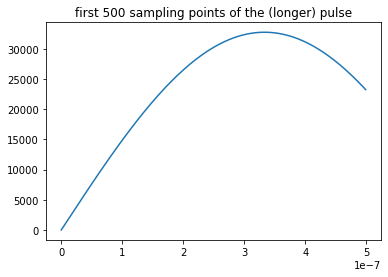

In [8]:
# The pulse

SAMPLING_RATE = 1e9 # random value, give more or less resolution in the signal
pulse_length = 0.3e-3
faxial = 27266 + 713000
fcyclotron = 16664089
fmagnetron = 10e3
fcenter = int(fcyclotron - faxial)
fcenter = int(faxial + fmagnetron) 

t=np.arange(0,pulse_length,1/SAMPLING_RATE) # length of conversion pulse
signal=np.sin(2*np.pi*t*fcenter) # signal data (basically time domain data)
normalized_signal = np.int16((signal / signal.max()) * 32767)
plt.plot(t[:500],normalized_signal[:500])
plt.title('first 500 sampling points of the (longer) pulse')
plt.show()

37513
center conv 37513 750260.0 4913474616.089656
pos dipol 833204 16664080.0 136682.31999299666
pos axial 37013 740260.0 1682656.5102350824
amplitude ratio, conversion frequency / cyclotron frequency 2.7817854099707153e-05 -91.11352750025178 dB
amplitude ratio, conversion frequency / axial frequency 0.0003424575563543278 -69.30786493209337 dB


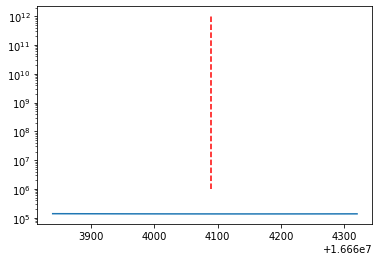

nu_axial/ t_pulse 2467553333.3333335


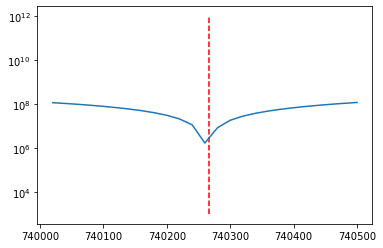

In [9]:
# zero padding for better resolution
zero_t = 0.05- pulse_length
signal = np.append(normalized_signal, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )

# or not
#signal = normalized_signal

# Number of samples 
N = len(signal)

# FFT
yf = fft(signal)
xf = fftfreq(N, 1 / SAMPLING_RATE)

# get index positions and amplitudes
#idx_conv = int(np.where(xf-fcenter == 0)[0])

print((np.abs(xf-fcenter)).argmin())

idx_conv = (np.abs(xf-fcenter)).argmin()
idx_dipo = (np.abs(xf-fcyclotron)).argmin()
idx_axial = (np.abs(xf-faxial)).argmin()
#idx_dipo = int(np.where(xf-fcyclotron == 0)[0])
#idx_axial = int(np.where(xf-faxial == 0)[0])
print('center conv', idx_conv, xf[idx_conv], np.abs(yf[idx_conv]) )
print('pos dipol', idx_dipo, xf[idx_dipo], np.abs( yf[idx_dipo]) )
#print('pos dipol', idx_dipo, xf[idx_dipo], np.abs(yf[idx_dipo-50:idx_dipo+50]).max() )
print('pos axial', idx_axial, xf[idx_axial], np.abs( yf[idx_axial]) )
#print('pos axial', idx_axial, xf[idx_axial], np.abs(yf[idx_axial-50:idx_axial+50]).max() )
#print('pos axial', idx_axial, xf[idx_axial-50:idx_axial+50], np.abs(yf[idx_axial-50:idx_axial+50]) )

# amplitude ratios
dz_qxy_ratio = np.abs(yf[idx_dipo])/np.abs(yf[idx_conv])
#dz_qxy_ratio = np.abs(yf[idx_dipo-50:idx_dipo+50]).max()/np.abs(yf[idx_conv])
dz_qxy_ratio_axial = np.abs(yf[idx_axial])/np.abs(yf[idx_conv])
#dz_qxy_ratio_axial = np.abs(yf[idx_axial-50:idx_axial+50]).max()/np.abs(yf[idx_conv])
print('amplitude ratio, conversion frequency / cyclotron frequency', dz_qxy_ratio, 20*np.log10(dz_qxy_ratio), 'dB')
print('amplitude ratio, conversion frequency / axial frequency', dz_qxy_ratio_axial, 20*np.log10(dz_qxy_ratio_axial), 'dB')

span = 500 

x_cyclo = xf[np.where(abs(xf-fcyclotron) < span/2)]
y_cyclo = yf[np.where(abs(xf-fcyclotron) < span/2)]
plt.plot(x_cyclo, np.abs(y_cyclo))
plt.yscale("log")
#plt.ylim([1e6, 1e12])
plt.vlines([fcyclotron], 1e6, 1e12, colors='r', linestyles='dashed')
plt.show()

print("nu_axial/ t_pulse", faxial/pulse_length)
x_axial = xf[np.where(abs(xf-faxial) < span/2)]
y_axial = yf[np.where(abs(xf-faxial) < span/2)]
plt.plot(x_axial, np.abs(y_axial))
plt.yscale("log")
#plt.ylim([1e6, 1e12])
plt.vlines([faxial], 1e3, 1e12, colors='r', linestyles='dashed')
plt.show()

#Whats the gain by resonator?

### This does not seem to be a likely reason for the effect.

The conversion pulse amplitude at the resonant frequency for the direct excitation of the cyclotron motion is reduced by -97 dB. This is 1e-5 times smaller amplitude than the amplitude of the actual conversion pulse. If our amplitude on the function generator is lets say 10V, the corrisponding amplitude for direct excitation would be 1mV. That this would result in an excitation is at least questionable.

## What else could be the reason?

### The function generator: Trigger delay jitter / periodic offset

period length in ns 60.24096385542168
l period length in ns 1428.5714285714287
ns/° 0.16733601070950468 *4 0.6693440428380187
0.0 0.07000000576954335


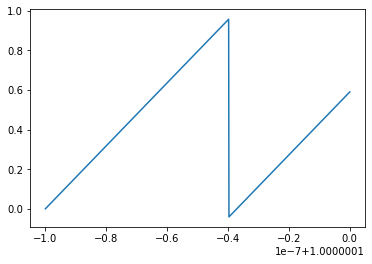

1001 1001 10 1010


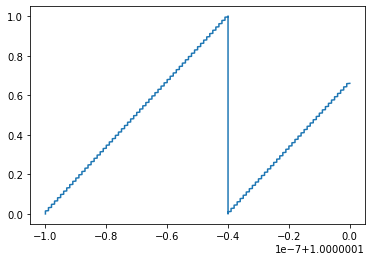

In [5]:
sampling_rate = 660e6 # samples per second
trigger_delay_resolution = 1e-9 # 4 ns

fcenter = 16.6e6 # 
tperiod = 1/fcenter
PAT_resolution = 1e-10
print('period length in ns', tperiod*1e9)
local = 700e3
lperiod = 1/local
print('l period length in ns', lperiod*1e9)

# how many nano seconds per degree?
print('ns/°', tperiod*1e9/360, '*4', tperiod*1e9*4/360)

time = np.arange(1.0, 1.0+1e-7, PAT_resolution) # 100ns in 1ns steps
ion_phase = (time*fcenter - (time*fcenter).astype('int32'))
local_phase = (time*local - (time*local).astype('int32'))
print(local_phase.min(), local_phase.max())
plt.plot(time, ion_phase-local_phase)
plt.show()

repeat = int(trigger_delay_resolution / PAT_resolution)
trigger_times = np.repeat(np.arange(1.0, 1.0+1e-7, trigger_delay_resolution), repeat) # 4ns steps (RF 33600 series)
print(len(time), len(ion_phase), repeat, len(trigger_times))
plt.plot(trigger_times[:len(ion_phase)], ion_phase)
plt.show()

### Mixer and fft:

In [6]:
LO = 700e3
RF = 730e3
fcenter = RF-LO
SAMPLING_RATE = 1000e6 # samples per second
SAMPLING_RATE_SOUNDCARD = 192000
print(1/SAMPLING_RATE, 1/SAMPLING_RATE_SOUNDCARD, SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)

aLO = 10
aRF = 1
length = 10e-3
t=np.arange(0,length,1/SAMPLING_RATE) # sampling rate of the LO!!! not of the soundcard!
sLO=aLO*np.sin(2*np.pi*t*LO) # signal data (basically time domain data)

zero_t = 0.05 - length

1e-09 5.208333333333333e-06 5208.333333333333


In [7]:
phases = np.linspace(0, 2*np.pi, 20)
read_phase = []
read_amp = []
for phase in phases:
    pRF = phase # phase offset
    sRF=aRF*np.sin(2*np.pi*t*RF+pRF) # signal data (basically time domain data)
    
    # mixing & normalizing
    sMI = sRF*sLO
    
    #plt.plot(t[:10000], sMI[:10000])
    #plt.show()
    sMI = np.int16((sMI / sMI.max()) * 32767)

    # zero padding
    signal = np.append(sMI, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )
    
    # resampling with slower soundcard:
    old_N = len(signal)
    # ether picking the samples
    #signal = signal[::int(SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)]
    
    # or mean the sub arrays
    sampling_ratio = SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD
    mean_size = int(sampling_ratio)
    over_cut = old_N%mean_size
    print(sampling_ratio, mean_size, over_cut)
    if over_cut != 0:
        signal = np.mean(signal[:-over_cut].reshape(-1, mean_size), axis=1)
    else:
        signal = np.mean(signal.reshape(-1, mean_size), axis=1)

        
    #plt.plot(signal[:100])
    #plt.show()
    
    # Number of samples 
    N = len(signal)
    #print('original N', old_N, 'down sampled', N)

    # Fourier transform
    yf = fft(signal)
    xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

    # where to look
    idx_conv = (np.abs(xf - fcenter)).argmin()
    #print(idx_conv, xf[idx_conv])
    
    # get phase
    rp = np.angle(yf[idx_conv])
    if rp < 0:
        rp +=2*np.pi
    #print('rfphase', phase, 'fft phase', rp)
    read_phase.append( rp )
    read_amp.append( np.abs(yf[idx_conv]) )

#plt.plot(read_phase)
#plt.show()
read_phase = np.unwrap(read_phase)
#plt.plot(read_phase)
#plt.show()
read_phase -= read_phase.min()
#plt.plot(read_phase)
#plt.show()
diff_phase = phases - read_phase
plt.plot(phases, diff_phase/2/np.pi*360)
plt.title("diff phase")
plt.show()
plt.plot(phases, read_amp)
plt.title("amplitude vs phase")
plt.show()

add_phase = phases + read_phase
add_phase -= add_phase.min()
plt.plot(phases, add_phase/2/np.pi*360)
plt.title("add phase")
plt.show()

5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200


KeyboardInterrupt: 

## resonator excitation due to coupling pulse and **just** the underlying signal (no axial excitation)

In [ ]:
phases = np.linspace(0, 2*np.pi, 20)
read_phase = []
read_amp = []

dbRES = -25
aRES = aRF*10**(dbRES/20)
print(aRF, aRES)
sRES=aRES*np.sin( 2*np.pi*t*RF+130/360*2 )

for phase in phases:
    pRF = phase # phase offset
    sRF=aRF*np.sin(2*np.pi*t*RF+pRF) # signal data (basically time domain data)
    #plt.plot(t[:10000], sRF[:10000])

    # adding resonator signal
    sADDED = sRF + sRES
    #plt.plot(t[:10000], sRF[:10000])
    #plt.show()
    
    # mixing & normalizing
    sMI = sADDED*sLO
    
    sMI = np.int16((sMI / sMI.max()) * 32767)

    # zero padding
    signal = np.append(sMI, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )
    
    # resampling with slower soundcard:
    old_N = len(signal)
    # ether picking the samples
    signal = signal[::int(SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)]
    
    # or mean the sub arrays
    sampling_ratio = SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD
    mean_size = int(sampling_ratio)
    over_cut = old_N%mean_size
    #print(sampling_ratio, mean_size, over_cut)
    #if over_cut != 0:
    #    signal = np.mean(signal[:-over_cut].reshape(-1, mean_size), axis=1)
    #else:
    #    signal = np.mean(signal.reshape(-1, mean_size), axis=1)

        
    #plt.plot(signal[:100])
    #plt.show()
    
    # Number of samples 
    N = len(signal)
    #print('original N', old_N, 'down sampled', N)

    # Fourier transform
    yf = fft(signal)
    xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

    # where to look
    idx_conv = (np.abs(xf - fcenter)).argmin()
    #print(idx_conv, xf[idx_conv])
    
    # get phase
    rp = np.angle(yf[idx_conv])
    if rp < 0:
        rp +=2*np.pi
    amp = np.abs( yf[idx_conv] )
    print('rfphase', phase, 'fft phase', rp, "fft amp", amp )
    read_phase.append( rp )
    read_amp.append( amp )

#plt.plot( read_phase )
#plt.show()
read_phase = np.unwrap( read_phase )
plt.plot(phases, read_phase)
plt.show()
read_phase -= read_phase.min()
#plt.plot(read_phase)
#plt.show()
diff_phase = phases - read_phase
plt.plot(phases, diff_phase/2/np.pi*360)
plt.title("diff phase")
plt.show()

# normalize amp
read_amp -= np.min(read_amp)
plt.plot(phases, read_amp)
plt.title("amplitude vs phase")
plt.show()

add_phase = phases + read_phase
add_phase -= add_phase.min()
plt.plot(phases, add_phase/2/np.pi*360)
plt.title("add phase")
plt.show()

### Thats it?

This could be it. This is an underlying signal due to excitation of the resonator. 

#### But it is not (kind of):
We tested this and the resonator signal relaxes ultra fast. In combination with our fft_delay of 5 ms (waiting after the coupling pulse before we start acquiring the signal) the resonator signal is long gone. How did we test it? We increased the fft delay step by step up to 100 milliseconds and checked how the non-linear phase effect changes. If it would be the underlying signal of the resonator, which is definitly at some rate relaxing, the amplitude of this non linear phase effect would have to decrease. That was not the case. This supports the idea that the real phase of the ion is effected, either radially or axially.

#### Still:
Since we see this excitation of the resonator (with a fixed phase due to the phase of the coupling pulse) it might be possible that its still in some way the origin, e.g. by exciting the axial motion. If this is the case the axial phase will be effected directly at the time of the coupling and the effect will not change with longer fft delay. So that would fit. So how do we test that? Two possibilities: off resonant measurement, which might be less effected by the resonator signal or **shaping the pulse** (like Sven suggested) with a **window function** to reduce the amplitude of the slopes (see FFT) and theirby not excite the resonator. **This was successfully tested and the theory correct!**


## Another prospect due to this:

Since the axial frequency modifies the phase on readout, we can also check the jitter of the phase readout due to a random phase in the axial mode:

What we see when executig the cells below is that with routhly -16dB axial signal with a random phase we get the phase jitter of 7/8 degree we typically see.

**What we also see**
If we somehow fix this phase, e.g. by an axial excitation just before the coupling, we would go down to sub degree stability even with a SNR of just -5 db.
**AMAZING**

In [ ]:
axial_phases = np.random.rand(30)*2*np.pi
#axial_phases = np.random.rand(30)*2*np.pi/180 # make it stable to 2 degree by axial excitation just before the coupling.
print(np.mean(axial_phases)*180/np.pi, np.std(axial_phases)*180/np.pi)
plt.hist(axial_phases)
plt.show()

In [ ]:
dblist = [-3, -6, -10, -16, -20, -90]

mean_phases = []
std_phases = []

for db in dblist:

    dbAXIAL = db
    aAXIAL = aRF*10**(dbAXIAL/20)
    print(db, aRF, aAXIAL, aAXIAL/aRF)

    sRF=aRF*np.sin(2*np.pi*t*RF) # signal data (basically time domain data)

    read_phase = []
    read_amp = []

    for phase in axial_phases:
        sAXIAL=aAXIAL*np.sin( 2*np.pi*t*RF + phase)
        #plt.plot(t[:10000], sRF[:10000])

        # adding resonator signal
        sADDED = sRF + sAXIAL
        #plt.plot(t[:10000], sRF[:10000])
        #plt.show()

        # mixing & normalizing
        sMI = sADDED*sLO

        sMI = np.int16((sMI / sMI.max()) * 32767)

        # zero padding
        signal = np.append(sMI, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )

        # resampling with slower soundcard:
        old_N = len(signal)
        # ether picking the samples
        signal = signal[::int(SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)]

        # or mean the sub arrays
        sampling_ratio = SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD
        mean_size = int(sampling_ratio)
        over_cut = old_N%mean_size
        #print(sampling_ratio, mean_size, over_cut)
        #if over_cut != 0:
        #    signal = np.mean(signal[:-over_cut].reshape(-1, mean_size), axis=1)
        #else:
        #    signal = np.mean(signal.reshape(-1, mean_size), axis=1)


        #plt.plot(signal[:100])
        #plt.show()

        # Number of samples 
        N = len(signal)
        #print('original N', old_N, 'down sampled', N)

        # Fourier transform
        yf = fft(signal)
        xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

        # where to look
        idx_conv = (np.abs(xf - fcenter)).argmin()
        #print(idx_conv, xf[idx_conv])

        # get phase
        rp = np.angle(yf[idx_conv])
        if rp < 0:
            rp +=2*np.pi
        amp = np.abs( yf[idx_conv] )
        print('rfphase', phase, 'fft phase', rp, "fft amp", amp )
        read_phase.append( rp )
        read_amp.append( amp )

    read_phase = np.unwrap( read_phase ) * 180/np.pi
    plt.title("read phases")
    plt.plot(read_phase)
    plt.show()

    plt.hist(read_phase)
    plt.show()
    mean = np.mean(read_phase)
    std = np.std(read_phase)
    print(db, mean, std)
    mean_phases.append(mean)
    std_phases.append(std)
    


In [ ]:


plt.plot(dblist, np.unwrap(np.asarray(mean_phases)/180*np.pi)*180/np.pi)
plt.show()
plt.plot(-np.asarray(dblist), std_phases)
plt.show()

## What happens if I have a periodic waiting time (accumulation time) error?

First: How can this happen? If you transfere your waiting time to anouther unit, being samples of the function generator, where you have not only a time-quantization due to the sampling rate (500 MSa/s -> 2 ns/Sample) but maybe also programming limitations, like a minimal size for a arbitrary signal segment of 12 samples -> 24 ns (given by the function generator) or in the arbitrary script itself some rounding/conversion errors in that case.

Lets assume we do our non-linearity check measurement: We find a few PATs (in ms steps oor higher so we can ignore the local oszillator) with which we span the 2pi range for the current ions frequency / phase readout. Then we want to see either a flat line of phase - phase residuals or the discussed sinusoidial effekt. But what if we have PAT errors? How does the data look like and can we by accident create a sinusoidial like result?

In [ ]:
# lets prepare the PATs like we would for a measurement, but also later much much more for easier check...
RF_SAMPLE_RATE = 500e6
MAX_SEQ_COUNT = int(1e6) 
MIN_SEQ_MEMORY_POINTS = int(32)

freq = fcyclotron
freq = 25070660.855
print("frequency", freq)
PATs = np.arange(1,1.1,0.004)
#PATs = np.arange(1,1.1,2e-9)
phases = ( freq * PATs ) % (2*np.pi)
plt.plot(PATs, phases)
plt.show()
plt.hist(phases, 100)
plt.show()

In [ ]:
# convert PATs to samples and back:
def time_to_samples(time):
    return np.round(RF_SAMPLE_RATE * time).astype('int')

def time_to_segment(time)
    samples = time_to_samples(time)
    segments = []
    
    for these_samples in samples:
        if these_samples / MAX_SEQ_COUNT < MIN_SEQ_MEMORY_POINTS:
            while True:
                segment_repetition = total_samples / min_segment_size
                if round(segment_repetition,9) % 1 !=0: #check if the number is integer
                    min_segment_size += 1
                    continue
                else:
                    wait_pulse = (int(min_segment_size), int(segment_repetition))
                break
        else:
            while True:
                samples_in_segment = total_samples / segment_repetition
                if round(samples_in_segment,9) % 1 !=0: #check if the number is integer
                    segment_repetition -= 10 #ideally it should be -=1, but it seems to be working with 10, saving the computational time
                    continue
                else:
                    wait_pulse = (int(samples_in_segment), int(segment_repetition))
                break
        segments.append(wait_pulse)
    return segments
        
def samples_to_time(samples):
    return np.round(samples / RF_SAMPLE_RATE,9)

In [ ]:
PATSa = time_to_samples(PATs)
diff_PATs = samples_to_time(PATSa) - PATs
plt.plot(diff_PATs)

### So, the conversion is fine for ms steps

But for 4e-6 s steps it becomes a 1e-12 seconds error (which is very wierd) and for 4e-9 / 2e-9 s steps it becomes a 1e-9 seconds error (please try it out)

In [ ]:
# lets prepare the PATs like we would for a measurement, but also later much much more for easier check...

mfreq = freq - 0.01
print("frequency", mfreq)
mphases = ( mfreq * PATs ) % (2*np.pi)
plt.plot(mphases, phases)
plt.show()
plt.plot(phases, mphases-phases)
plt.show()

## Window functions for pulses:

In order to keep the same power, windowed pulses have to be adjusted in length. The results below show that the tukey window need smallest scaling/time increase and e.g. flattop a really big one. Since the Axial peak on the resonator has a limited life time (except feedback is used), the flattop gehts beaten by it.

In [ ]:
from scipy.signal import windows
plt.rcParams["figure.figsize"] = (20,10)

RF = 20e6
LO = 20.01e6
f_sideband = LO - RF
SR = 200e6
pi_time = 16e-3
print("RF", RF, "LO", LO, "f_sideband", f_sideband, "SR", SR, "pi time", pi_time)

window_types = [["no window", 1], [("hamming"), 1], [("blackman"), 1], [("hann"), 1], [("tukey", 0.5), 1], [("flattop"), 1]]
window_types = [["no window", 1], [("hann"), 2.13], [("tukey", 0.5), 1.335], [("flattop"), 4.62]]
window_types = [["no window", 1], [("flattop"), 4.62], [("hann"), 2.0],  [("tukey", 0.5), 1.335]]
#window_types = [[("flattop"), 4.62], [("tukey", 0.5), 1.335]]

no_window_amp = 0

colors = ["b-", "r-", "g-", "y-", "k-", "c-"]

for idx, setting in enumerate(window_types):
    scaling = setting[1]
    wtype = setting[0]
    
    # pulse
    pulse_length = pi_time * scaling
    t = np.linspace(0, pulse_length, int(pulse_length*SR)+1)
    pulse_original = np.sin( 2*np.pi*t*RF + 0)
    sLO = np.sin( 2*np.pi*t*LO + 0)
    print(wtype, t.max())

    # window function
    if wtype != "no window":
        window = windows.get_window(wtype, len(pulse_original), fftbins=False)
    else:
        window = np.ones(len(pulse_original))
    
    #print("integral", sum(window))
    #plt.plot(window)
    #plt.show()
    signal = pulse_original*window
    #print(pulse_windowed)

    #plt.plot(t, pulse)
    #plt.show()

    # mixing
    signal = signal*sLO
    #print(pulse)

    # normalization
    signal = np.int16((signal / pulse.max()) * 32767)

    # zero padding
    signal = np.append(signal, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )

    # down_sampling
    signal = signal[::int(SR/SAMPLING_RATE_SOUNDCARD)]
    #print(signal, len(signal))
    #plt.plot(signal)
    #plt.show()

    # Fourier transform
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

    # where
    idx_conv = (np.abs(xf - f_sideband)).argmin()

    # get phase
    span = 5e2
    indexes = np.where( abs(xf - f_sideband) < span )
    freqs = xf[indexes]
    phases = np.angle(yf[indexes])
    amps = np.abs(yf[indexes])
    
    centeramp = np.abs(yf[idx_conv])
    if wtype == "no window":
        no_window_amp = centeramp
    print("amp ratio", centeramp/no_window_amp)
    # show spec
    plt.plot(freqs, amps, colors[idx], label=wtype)
    #plt.plot(freqs, phases, colors[idx], label=wtype)

#plt.yscale('log')
plt.legend()
plt.show()

705000.0
blackman 0.01
500001
70500 70000
amp RF 293124433.4234146
amp AXIAL 488.6129155218287
amp ratio 1.6669129550726788e-06
hann 0.01
500001
70500 70000
amp RF 333446936.0955552
amp AXIAL 1249.0889323646145
amp ratio 3.745990132614881e-06
('tukey', 0.5) 0.01
500001
70500 70000
amp RF 446202734.36677647
amp AXIAL 5598.694521244671
amp ratio 1.2547423155507987e-05
flattop 0.01
500001
70500 70000
amp RF 175541597.50931937
amp AXIAL 1361.5853446920798
amp ratio 7.756482588805165e-06


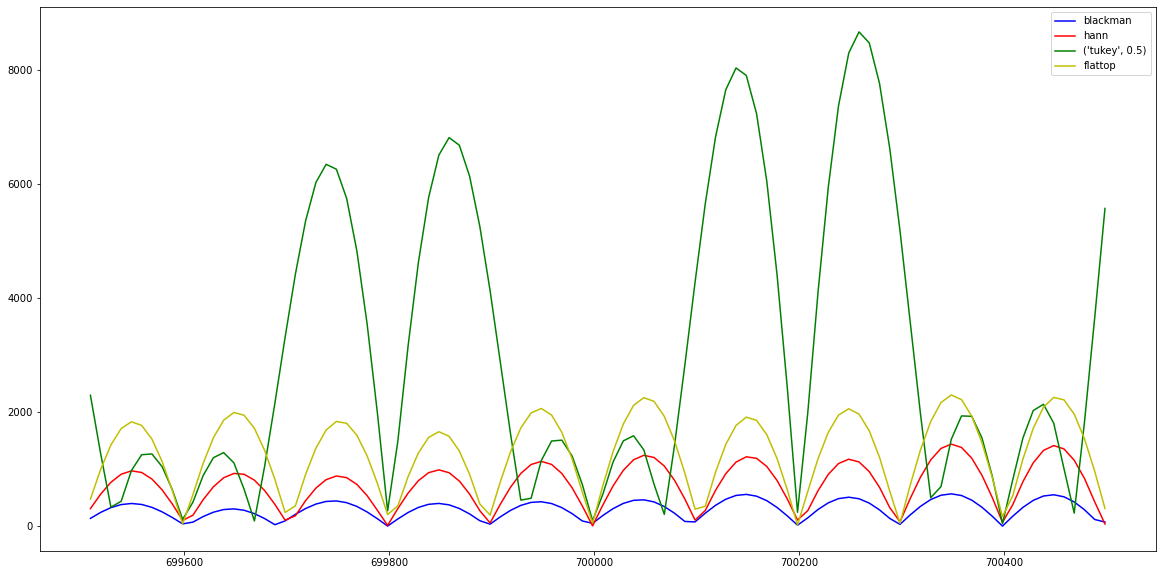

In [58]:
from scipy.signal import windows
plt.rcParams["figure.figsize"] = (20,10)

AXIAL = 700e3
MAG = 5e3
RF = AXIAL + MAG
print(RF)
pi_time = 10e-3
SR = 5e6

window_types = [["no window", 1], [("hamming"), 1], [("blackman"), 1], [("hann"), 1], [("tukey", 0.5), 1], [("flattop"), 1]]
window_types = [[("blackman"), 1], [("hann"), 1], [("tukey", 0.5), 1], [("flattop"), 1]]
#window_types = [["no window", 1], [("hann"), 2.13], [("tukey", 0.5), 1.335], [("flattop"), 4.62]]
#window_types = [["no window", 1], [("flattop"), 4.62], [("hann"), 2.0],  [("tukey", 0.5), 1.335]]
#window_types = [[("flattop"), 6.70], [("hann"), 6.9],  [("tukey", 0.5), 1.0]]
#window_types = [[("flattop"), 4.62], [("tukey", 0.5), 1.335]]

no_window_amp = 0

colors = ["b-", "r-", "g-", "y-", "k-", "c-"]

for idx, setting in enumerate(window_types):
    scaling = setting[1]
    wtype = setting[0]
    
    # pulse
    pulse_length = pi_time * scaling
    t = np.linspace(0, pulse_length, int(pulse_length*SR)+1)
    pulse_original = np.sin( 2*np.pi*t*RF + 0)
    print(wtype, t.max())

    zero_t = 0.1 - pulse_length
    
    # window function
    if wtype != "no window":
        window = windows.get_window(wtype, len(pulse_original), fftbins=False)
    else:
        window = np.ones(len(pulse_original))
    signal = pulse_original*window

    # normalization
    signal = np.int16((signal / signal.max()) * 32767)
    #plt.plot(t, signal)
    #plt.show()

    # zero padding
    signal = np.append(signal, np.zeros(int(zero_t*SR), dtype=np.int16) )
    print(len(signal))
        
    # Fourier transform
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / SR)
    
    #plt.plot(xf, np.abs(yf))
    #plt.show()
    
    # where
    idx_RF = (np.abs(xf - RF)).argmin()
    idx_AXIAL = (np.abs(xf - AXIAL)).argmin()
    print(idx_RF, idx_AXIAL)

    # cut
    span = 5e2 # 1.5*MAG
    indexes = np.where( abs(xf - AXIAL) < span )
    freqs = xf[indexes]
    phases = np.angle(yf[indexes])
    amps = np.abs(yf[indexes])
        
    halfspan = int(span/2)
    amp_RF = np.mean(np.abs(yf[idx_RF-10:idx_RF+10]))
    amp_AX = np.mean(np.abs(yf[idx_AXIAL-halfspan:idx_AXIAL+halfspan]))
    print("amp RF", amp_RF)
    print("amp AXIAL", amp_AX)
    print("amp ratio", amp_AX/amp_RF)
    # show spec
    plt.plot(freqs, amps, colors[idx], label=wtype)
    #plt.plot(freqs, phases, colors[idx], label=wtype)

#plt.yscale('log')
plt.legend()
plt.show()

In [117]:
# What if the coupling pulse has different lengths? resulting in an shift compared to the local oscillator and soundcard?
diffs = []
for off in range(1,32):
    sampling_rate_RF = 660e6
    offsamples = 0
    offT = 1/sampling_rate_RF*offsamples
    print(offT)

    sampling_rate_signal = 19.2e6
    off_samples_signal = np.around(offT/(1/sampling_rate_signal))
    print(off_samples_signal)
    tsig_off = off_samples_signal/sampling_rate_signal + 0.001
    print(tsig_off)

    t = np.arange(0+tsig_off, 1e-2+tsig_off, 1/sampling_rate_signal)
    print("t step signal", t[1]-t[0])
    print(t[:4], t[-4:])
    faxial = 701.345342e3
    phiaxial = 177
    saxial = np.sin(2*np.pi*(t+offT)*faxial+phiaxial)
    fLO = 690e3
    sLO = np.sin(2*np.pi*t*fLO)
    sMIX = sLO*saxial

    # FFT
    N = len(sMIX)
    yf = fft(sMIX)
    xf = fftfreq(N, 1 / (sampling_rate_signal) )

    amp = np.abs(yf)
    phase = np.angle(yf)

    #plt.plot(xf, amp)
    #plt.xlim([1e2,2e4])
    #plt.show()

    sMIXdown = sMIX[::100]
    tdown = t[::100]
    print("t step ADC", tdown[1]-tdown[0])
    #plt.plot(tdown, sMIXdown)
    #plt.show()

    # FFT
    N = len(sMIXdown)
    yf = fft(sMIXdown)
    xf = fftfreq(N, 1 / (sampling_rate_signal/100) )

    amp = np.abs(yf)
    phase = np.angle(yf)

    #plt.plot(xf, amp)
    #plt.xlim([1e2,2e4])
    #plt.show()

    #plt.plot(xf, phase)
    #plt.xlim([1e2,2e4])
    peakf = faxial-fLO
    peakidx = np.argwhere(xf == peakf)
    peakidx = (np.abs(xf - peakf)).argmin()
    phi1 = phase[peakidx]/2/np.pi*360
    print("phase in degree", phi1)
    #plt.show()


    # compare 
    phiaxial = 0
    saxial = np.sin(2*np.pi*(t+offT)*(faxial+off/10)+phiaxial)
    fLO = 690e3
    sLO = np.sin(2*np.pi*t*fLO)
    sMIX = sLO*saxial

    sMIXdown = sMIX[::100]
    tdown = t[::100]
    print("t step ADC", tdown[1]-tdown[0])
    #plt.plot(tdown, sMIXdown)
    #plt.show()

    # FFT
    N = len(sMIXdown)
    yf = fft(sMIXdown)
    xf = fftfreq(N, 1 / (sampling_rate_signal/100) )

    amp = np.abs(yf)
    phase = np.angle(yf)

    #plt.plot(xf, amp)
    #plt.xlim([1e2,2e4])
    #plt.show()

    #plt.plot(xf, phase)
    #plt.xlim([1e2,2e4])
    peakf = faxial-fLO
    peakidx = np.argwhere(xf == peakf)
    peakidx = (np.abs(xf - peakf)).argmin()
    phi2 = phase[peakidx]/2/np.pi*360
    print("phase in degree", phi2)
    print("diffe in degree", phi2-phi1)
    diffs.append(phi2-phi1)
    #plt.show()

diffs = np.asarray(diffs)
print(diffs-np.min(diffs))

0.0
0.0
0.001
t step signal 5.208333333324086e-08
[0.001      0.00100005 0.0010001  0.00100016] [0.01099979 0.01099984 0.0109999  0.01099995]
t step ADC 5.208333333324086e-06
phase in degree -92.71584238133251
t step ADC 5.208333333324086e-06
phase in degree -153.90845283589883
diffe in degree -61.19261045456632
0.0
0.0
0.001
t step signal 5.208333333324086e-08
[0.001      0.00100005 0.0010001  0.00100016] [0.01099979 0.01099984 0.0109999  0.01099995]
t step ADC 5.208333333324086e-06
phase in degree -92.71584238133251
t step ADC 5.208333333324086e-06
phase in degree -153.69295909828972
diffe in degree -60.97711671695721
0.0
0.0
0.001
t step signal 5.208333333324086e-08
[0.001      0.00100005 0.0010001  0.00100016] [0.01099979 0.01099984 0.0109999  0.01099995]
t step ADC 5.208333333324086e-06
phase in degree -92.71584238133251
t step ADC 5.208333333324086e-06
phase in degree -153.47746335323657
diffe in degree -60.761620971904065
0.0
0.0
0.001
t step signal 5.208333333324086e-08
[0.001 

t step ADC 5.208333333324086e-06
phase in degree -92.71584238133251
t step ADC 5.208333333324086e-06
phase in degree -148.08928793369964
diffe in degree -55.37344555236713
0.0
0.0
0.001
t step signal 5.208333333324086e-08
[0.001      0.00100005 0.0010001  0.00100016] [0.01099979 0.01099984 0.0109999  0.01099995]
t step ADC 5.208333333324086e-06
phase in degree -92.71584238133251
t step ADC 5.208333333324086e-06
phase in degree -147.8737245134302
diffe in degree -55.1578821320977
0.0
0.0
0.001
t step signal 5.208333333324086e-08
[0.001      0.00100005 0.0010001  0.00100016] [0.01099979 0.01099984 0.0109999  0.01099995]
t step ADC 5.208333333324086e-06
phase in degree -92.71584238133251
t step ADC 5.208333333324086e-06
phase in degree -147.6581579030088
diffe in degree -54.94231552167629
0.0
0.0
0.001
t step signal 5.208333333324086e-08
[0.001      0.00100005 0.0010001  0.00100016] [0.01099979 0.01099984 0.0109999  0.01099995]
t step ADC 5.208333333324086e-06
phase in degree -92.71584238

In [115]:
nures = 700123.323
short = 0.1
omc, omp, omz, omm, p, z, m = ideal.ion_stats("172Yb42+", nures)
omc, omp, omz, omm, p, z, m = ideal.ion_stats("12C6+", nures)
N = omp.n/2/np.pi*short
phase = N - np.around(N, 0)
print(phase*360)

nures += 10
omc, omp, omz, omm, p, z, m = ideal.ion_stats("172Yb42+", nures)
omc, omp, omz, omm, p, z, m = ideal.ion_stats("12C6+", nures)
N = omp.n/2/np.pi*short
phase = N - np.around(N, 0)
print(phase*360)

(2.6+/-0.7)e+02
correlation matrix failed:  'numpy.ndarray' object has no attribute 'derivatives'
radii (9.7+/-1.4)e-07 (5.9+/-0.8)e-06 (9.7+/-1.4)e-07
(5.4+/-1.5)e+02
correlation matrix failed:  'numpy.ndarray' object has no attribute 'derivatives'
radii (2.6+/-0.4)e-06 (2.24+/-0.32)e-05 (2.6+/-0.4)e-06
123.23957093060017
(2.6+/-0.7)e+02
correlation matrix failed:  'numpy.ndarray' object has no attribute 'derivatives'
radii (9.7+/-1.4)e-07 (5.9+/-0.8)e-06 (9.7+/-1.4)e-07
(5.4+/-1.5)e+02
correlation matrix failed:  'numpy.ndarray' object has no attribute 'derivatives'
radii (2.6+/-0.4)e-06 (2.24+/-0.32)e-05 (2.6+/-0.4)e-06
118.55051670223475
